In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/subtask_a_train.tsv
/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/subtask_a_train.tsvZone.Identifier
/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/subtask_a_train copy.tsv
/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/rat run/94938520064.pngZone.Identifier
/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/rat run/55855203654.pngZone.Identifier
/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/rat run/87303309822.png
/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/rat run/60896460729.png
/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/rat run/32737581165.pngZone.Identifier
/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/rat run/60896460729.pngZone.Identifier
/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/rat run/87303309822.pngZone.Identifier
/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/rat run/32737581165.png
/kaggle/input/admire-task-

In [2]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 5.3 MB/s eta 0:00:00


In [3]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AdamW

from peft import LoraConfig, get_peft_model, TaskType


In [4]:
import pandas as pd

# Load the TSV file to check its structure
file_path = '/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/subtask_a_train.tsv'
df = pd.read_csv(file_path, sep='\t')

# Display the first few rows to understand the structure
df.head()

,compound,subset,sentence_type,sentence,expected_order,image1_name,image1_caption,image2_name,image2_caption,image3_name,image3_caption,image4_name,image4_caption,image5_name,image5_caption
0,elbow grease,Train,idiomatic,It took a lot of elbow grease to get the old e...,"['35234427395.png', '53378381715.png', '399382...",35234427395.png,The image depicts a hand holding a sponge and ...,39938261459.png,The image depicts a hand wearing a yellow work...,53378381715.png,The image depicts a hand holding a duster with...,54879908369.png,The image depicts a person wearing knee pads a...,74852536462.png,The image depicts a person wearing a black out...
1,night owl,Train,idiomatic,"It's a constant battle for us, as he is a morn...","['61697797701.png', '93189810779.png', '893752...",00982495584.png,The image depicts a nighttime scene with a lar...,61697797701.png,The image depicts a cartoon-style illustration...,89375227504.png,The image depicts a cartoon-style owl perched ...,93189810779.png,The image depicts a cartoon-style illustration...,93541983868.png,"The image depicts a dumbbell, which is a commo..."
2,heart of gold,Train,idiomatic,Even the somewhat seedy failed private eye has...,"['86137977215.png', '78062290185.png', '542405...",54240592941.png,"The image depicts a large, metallic safe with ...",78062290185.png,The image depicts a joyful scene featuring a y...,86137977215.png,The image depicts a cartoon scene where a youn...,90660547751.png,"The image depicts a futuristic, stylized space...",92088849364.png,"The image depicts a stylized, artistic represe..."
3,agony aunt,Sample,idiomatic,ESA's Space Weather Office is like Europe's st...,"['83600499282.png', '57658144685.png', '025128...",02512838127.png,The image depicts a serene outdoor scene featu...,32964421720.png,The image depicts a cartoon-style illustration...,57658144685.png,The image depicts a scene of a person sitting ...,83600499282.png,"The image depicts a person sitting at a desk, ...",92533456778.png,The image depicts a cartoon character of a wom...
4,shrinking violet,Train,idiomatic,"This aged, rich wine is no shrinking violet wi...","['77861539717.png', '68016869942.png', '118443...",11844321898.png,The image depicts a bouquet of purple tulips a...,45394842176.png,"The image depicts a magnifying glass, commonly...",68016869942.png,"The image depicts a small, cute puppy standing...",77861539717.png,The image depicts an animated character with c...,97482048489.png,The image is a colorful and vibrant illustrati...


In [5]:
import ast
def arrange_sentences(df):
    captions_ordered = []   
    
    for i in range(len(df)):
        order = df['expected_order'][i]
        image1_name = df['image1_name'].values[i]
        image2_name = df['image2_name'].values[i]
        image3_name = df['image3_name'].values[i]
        image4_name = df['image4_name'].values[i]
        image5_name = df['image5_name'].values[i]
        
        captions = []
        order = ast.literal_eval(order)
        for j in range(len(order)):
            image_name = order[j]
            if image_name == image1_name:
                captions.append(df['image1_caption'].values[i])
            elif image_name == image2_name:
                captions.append(df['image2_caption'].values[i])
            elif image_name == image3_name:
                captions.append(df['image3_caption'].values[i])
            elif image_name == image4_name:
                captions.append(df['image4_caption'].values[i])
            elif image_name == image5_name:
                captions.append(df['image5_caption'].values[i])
        captions_ordered.append(captions)

    return captions_ordered

captions_ordered = arrange_sentences(df)
df['captions_ordered'] = captions_ordered



In [6]:
print(df['captions_ordered'][0])

['The image depicts a hand holding a sponge and cleaning a glass cooktop stove. The cooktop is black with three circular burners, and there are some food residue stains on it. The sponge appears to be scrubbing off the stains, indicating that the person is cleaning the cooktop. The background is plain white, focusing attention on the cleaning activity.', 'The image depicts a hand holding a duster with a long, black and orange handle. The duster is being used to clean a surface, likely a ceiling or high wall, as indicated by the angle of the duster and the presence of dust particles being dislodged. The dust particles are shown in motion, suggesting that the duster is actively being used to remove dirt or debris from the surface. The background is plain white, which helps to emphasize the action taking place.', "The image depicts a hand wearing a yellow work glove holding a rusty metal pipe. The pipe is being dipped into a can of orange-colored paint. The paint is dripping from the pipe

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class AdMireDataset(Dataset):
    def __init__(self, df, max_length=512):
        self.max_length = max_length
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        compound = self.df.iloc[idx]['compound']
        sentence = self.df.iloc[idx]['sentence']
        captions = [
            self.df.iloc[idx]['image1_caption'],
            self.df.iloc[idx]['image2_caption'],
            self.df.iloc[idx]['image3_caption'],
            self.df.iloc[idx]['image4_caption'],
            self.df.iloc[idx]['image5_caption']
        ]

        caption1 = self.df.iloc[idx]['image1_caption']
        caption2 = self.df.iloc[idx]['image2_caption']
        caption3 = self.df.iloc[idx]['image3_caption']
        caption4 = self.df.iloc[idx]['image4_caption']
        caption5 = self.df.iloc[idx]['image5_caption']
        expected_order = self.df.iloc[idx]['captions_ordered']

        # expected_order contains sentences ordered, replace it with indices
        expected_order_indices = []
        for i in range(len(expected_order)):
            s = expected_order[i]
            if s == caption1:
                expected_order_indices.append(1)
            elif s == caption2:
                expected_order_indices.append(2)
            elif s == caption3:
                expected_order_indices.append(3)
            elif s == caption4:
                expected_order_indices.append(4)
            elif s == caption5:
                expected_order_indices.append(5)

        # Replace the compound in sentence and captions with [SEP] markers
        sentence = sentence.replace(compound, '[SEP] ' + compound + ' [SEP]')
        captions = [cap.replace(compound, '[SEP] ' + compound + ' [SEP]') for cap in captions]

        # Tokenize sentence and captions
        sentence_tokens = self.tokenizer(sentence, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        caption_tokens = [self.tokenizer(cap, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt') for cap in captions]

        # Find the token position of the compound (marked by [SEP] compound [SEP])
        # Compute compound position and convert it to a tensor
        num_compound_words = len(compound.split(' '))
        compound_position = torch.tensor(
            (sentence_tokens['input_ids'][0].tolist().index(self.tokenizer.convert_tokens_to_ids('[SEP]')) + 1 , num_compound_words),
            device=device  # Move to the correct device (GPU or CPU)
        )

        # Convert the list of caption positions to a tensor
        caption_positions = torch.tensor(
            [(cap['input_ids'][0].tolist().index(self.tokenizer.convert_tokens_to_ids('[SEP]')) + 1 , num_compound_words) for cap in caption_tokens],
            device=device  # Make sure the tensor is moved to the correct device (GPU or CPU)
        )


        expected_order_indices = np.array(expected_order_indices)
        expected_order_indices = torch.tensor(expected_order_indices, device = device)

        return sentence_tokens, caption_tokens, expected_order_indices, compound_position, caption_positions


In [9]:
dataset  = AdMireDataset(df)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
# Split the dataset indices
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)

# Create Subsets for training and validation
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)


In [11]:
dataloader = DataLoader(
    train_dataset,              # The dataset object
    batch_size=1,        # Adjust the batch size as needed
    shuffle=True,         # Shuffle data at each epoch
    collate_fn=None       # We can specify a custom collate_fn if necessary, but for now it's None
)

v_dataloader = DataLoader(
    val_dataset,              # The dataset object
    batch_size=1,        # Adjust the batch size as needed
    shuffle=False,         # Shuffle data at each epoch
    collate_fn=None       # We can specify a custom collate_fn if necessary, but for now it's None
)

In [12]:


class DualEncoderModelWithLoRA(nn.Module):
    def __init__(self, rank=4):
        super(DualEncoderModelWithLoRA, self).__init__()
        
        # Load the pre-trained BERT model and freeze it
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert.requires_grad_(False)  # Freeze all BERT parameters
        
        # Define LoRA configuration
        lora_config = LoraConfig(
            task_type=TaskType.FEATURE_EXTRACTION,
            r= rank,               # Rank of the LoRA matrices
            lora_alpha=16,     # Scaling factor
            lora_dropout=0.1,  # Dropout rate for LoRA layers
            target_modules=["query", "value"],  # Apply LoRA to these attention modules
        )
        
        # Apply LoRA to the BERT model
        self.bert1 = get_peft_model(self.bert, lora_config)
        self.bert2 = get_peft_model(self.bert, lora_config)
    def forward(self, sentence_tokens, caption_tokens, compound_position, caption_positions):

        # Anchor embedding (sentence compound)
        sentence_tokens = {k: v.squeeze(0) for k, v in sentence_tokens.items()}
        sentence_outputs = self.bert1(**sentence_tokens)
        
        # sentence_embedding = sentence_outputs.last_hidden_state[:, compound_position, :]
        # compound_position = compound_position[0]
        sentence_embedding = sentence_outputs.last_hidden_state[0][compound_position[0][0] : compound_position[0][0] + compound_position[0][1]] # (num_words,768)
        
        # Caption embeddings (captions compounds)
        caption_embeddings = []
        for i, cap_tokens in enumerate(caption_tokens):
            cap_tokens = {k: v.squeeze(0) for k, v in cap_tokens.items()}
            cap_outputs = self.bert2(**cap_tokens)
            cap_embedding = cap_outputs.last_hidden_state[0][caption_positions[0][i][0] : caption_positions[0][i][0] + caption_positions[0][i][1]]
            caption_embeddings.append(cap_embedding)
        
        return sentence_embedding, caption_embeddings


In [13]:
model = DualEncoderModelWithLoRA().to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
class RankingTripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(RankingTripletLoss, self).__init__()
        self.margin = margin
        self.cosine_similarity = nn.CosineSimilarity(dim=1)
    
    def forward(self, sentence_embedding, caption_embeddings, expected_order):
        loss = 0.0
        num_triplets = 0

        expected_order = expected_order[0]
        

        # Iterate over each pair of captions
        for i in range(len(expected_order) - 1):
            for j in range(i + 1, len(expected_order)):
                pos = caption_embeddings[expected_order[i] - 1]
                neg = caption_embeddings[expected_order[j] - 1]

                
                try:
                    # Calculate pairwise triplet loss
                    d_pos = self.cosine_similarity(sentence_embedding, pos)
                    d_neg = self.cosine_similarity(sentence_embedding, neg)
                    
                    # Weighted loss based on distance in order
                    weight = 1.0 / abs(i - j)
                    triplet_loss = weight * torch.relu(d_neg - d_pos + self.margin)
                    
                    loss += triplet_loss
                    num_triplets += 1
                except:
                    # print(i,j, expected_order,pos.shape , neg.shape , sentence_embedding.shape)
                    pass

        loss = loss / num_triplets if num_triplets > 0 else 0.0
        return loss.mean()


In [15]:
# Initialize criterion and optimizer
criterion = RankingTripletLoss(margin=1.0)  # Or any custom loss function
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop
num_epochs= 200
train_loss = []
val_loss_arr = []
best_val_loss = 1e6

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_train_loss = 0.0
    num_train_samples = 0
    print("Epoch", epoch + 1)
    
    for batch in dataloader:
        print(num_train_samples, end='\r')
        num_train_samples += 1

        # Unpack batch
        sentence_tokens, caption_tokens, expected_order, compound_positions, caption_positions = batch

        # Move tensors to device
        sentence_tokens = {k: v.to(device) for k, v in sentence_tokens.items()}
        caption_tokens = [{k: v.to(device) for k, v in cap.items()} for cap in caption_tokens]
        expected_order = expected_order.to(device)
        compound_positions = compound_positions.to(device)
        caption_positions = caption_positions.to(device)

        # Forward pass: compute embeddings for the anchor sentence and captions
        sentence_embedding, caption_embeddings = model(sentence_tokens, caption_tokens, compound_positions, caption_positions)
        
        # Compute loss: Ranking Triplet Loss for each batch
        loss = criterion(sentence_embedding, caption_embeddings, expected_order)
        total_train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(dataloader)
    train_loss.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}")

    # Validation Phase
    model.eval()
    total_val_loss = 0.0
    num_val_samples = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for batch in v_dataloader:
            num_val_samples += 1

            # Unpack batch
            sentence_tokens, caption_tokens, expected_order, compound_positions, caption_positions = batch

            # Move tensors to device
            sentence_tokens = {k: v.to(device) for k, v in sentence_tokens.items()}
            caption_tokens = [{k: v.to(device) for k, v in cap.items()} for cap in caption_tokens]
            expected_order = expected_order.to(device)
            compound_positions = compound_positions.to(device)
            caption_positions = caption_positions.to(device)

            # Forward pass
            sentence_embedding, caption_embeddings = model(sentence_tokens, caption_tokens, compound_positions, caption_positions)
            
            # Compute loss
            val_loss = criterion(sentence_embedding, caption_embeddings, expected_order)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(v_dataloader)
    val_loss_arr.append(avg_val_loss)

    if (val_loss_arr[-1] < best_val_loss):
        best_val_loss = val_loss_arr[-1]
        model_save_path = os.path.join('/kaggle/working/', f"model.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': best_val_loss
        }, model_save_path)
            




    
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1
Epoch 1, Train Loss: 0.6243669769120594
Epoch 1, Validation Loss: 0.6561345287731716
Epoch 2
Epoch 2, Train Loss: 0.621488083449621
Epoch 2, Validation Loss: 0.6559913754463196
Epoch 3
Epoch 3, Train Loss: 0.6228166865924049
Epoch 3, Validation Loss: 0.6558444840567452
Epoch 4
Epoch 4, Train Loss: 0.6238959412726145
Epoch 4, Validation Loss: 0.6557826825550624
Epoch 5
Epoch 5, Train Loss: 0.6233931571718246
Epoch 5, Validation Loss: 0.6556458898953029
Epoch 6
Epoch 6, Train Loss: 0.6237451850421845
Epoch 6, Validation Loss: 0.6554469551358905
Epoch 7
Epoch 7, Train Loss: 0.6229808321074833
Epoch 7, Validation Loss: 0.6551385181290763
Epoch 8
Epoch 8, Train Loss: 0.6232447671511817
Epoch 8, Validation Loss: 0.6546899591173444
Epoch 9
Epoch 9, Train Loss: 0.6234487749281383
Epoch 9, Validation Loss: 0.6541029300008502
Epoch 10
Epoch 10, Train Loss: 0.6248000898058452
Epoch 10, Validation Loss: 0.6536802223750523
Epoch 11
Epoch 11, Train Loss: 0.6216237696390303
Epoch 11, Validati

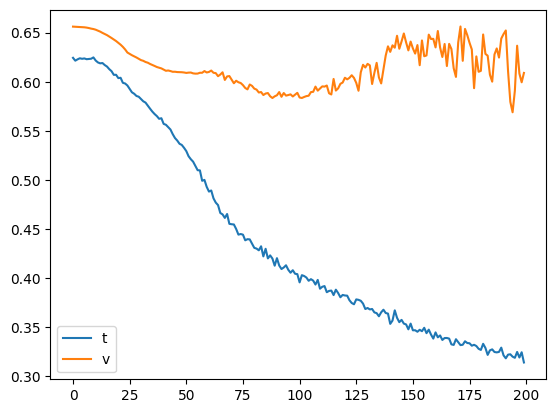

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='t')
plt.plot(val_loss_arr, label='v')
plt.legend()
plt.show()